In [1]:
source('../../function.r')

In [17]:
load('P29_preprocessing.image')

In [3]:
scatter_style2 <- function(ggplot_,legend_position='none',xlab_='PC1',ylab_='PC2',title='',
                          x.angle=0,ratio=1){
    sp <- ggplot_+theme_classic()+  
        #border()+
#         xlab(xlab_)+
#         ylab(ylab_)+
        ggtitle(title)+
        theme(legend.position=legend_position,
              title=element_text(size = 16, face = "bold"),
              aspect.ratio = ratio, 
              axis.line = element_line(size = 1, linetype = "solid"),
              axis.ticks.length=unit(.25, "cm"),
              axis.ticks = element_line(size = 1),
                axis.text.x = element_text(angle=x.angle,size = 16),
                axis.title.x = element_text(size = 16, face = "bold"),
                axis.text.y = element_text(size = 16),
                axis.title.y = element_text(size = 16, face = "bold"))
    return(sp)
}

scatter_style <- function(ggplot_,legend_position='none',xlab_='PC1',ylab_='PC2',title='',
                          x.angle=0,ratio=1){
    sp <- ggplot_+theme_classic()+  
        #border()+
#         xlab(xlab_)+
#         ylab(ylab_)+
        ggtitle(title)+
        theme(legend.position=legend_position,
              legend.key.size=unit(0.2,'cm'),
              legend.title=element_text(size=8),
              legend.text=element_text(size=8),
              title=element_text(size = 8, face = "bold"),
              aspect.ratio = ratio, 
                axis.text.x = element_text(angle=x.angle,size = 8),
                axis.title.x = element_text(size = 8, face = "bold"),
                axis.text.y = element_text(size = 8),
                axis.title.y = element_text(size = 8, face = "bold"))
    return(sp)
}

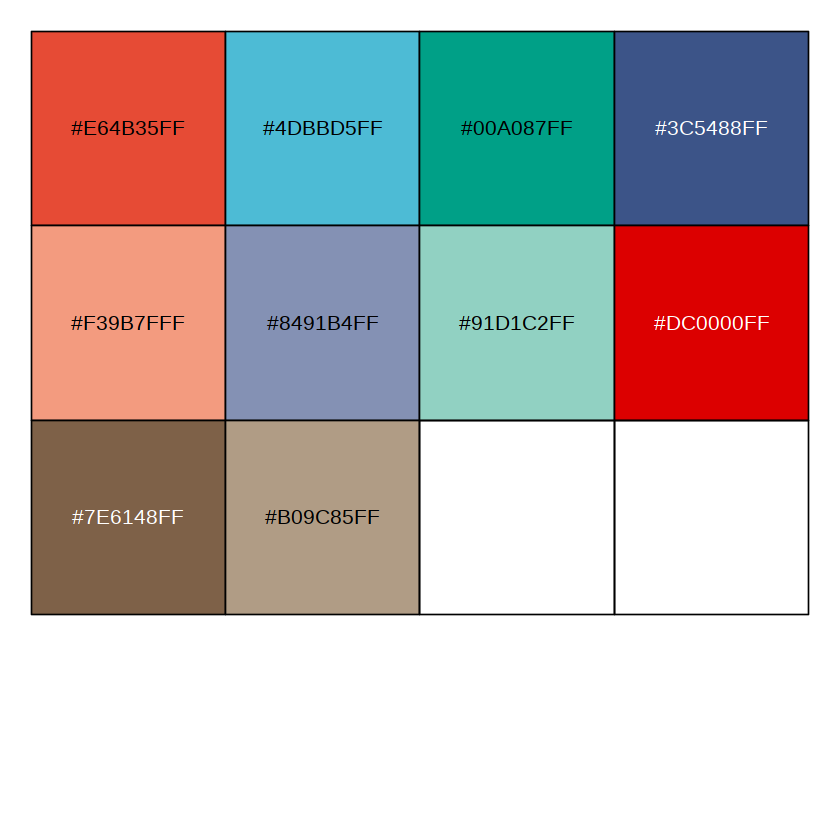

In [5]:
colors_ <- ggsci::pal_npg()(10)
scales::show_col(ggsci::pal_npg()(10))

In [6]:
color_ <- colors_[c(1,2)]

# PC selection

In [12]:
pc.select.sdev <- which(Z_pca_results$sdev >1)

In [13]:
pc.th = 45

In [14]:
select.pcs <- which((Z_pca_results$x)[,pc.select.sdev]%>%
                    apply(2,function(x){x%>%dip.test%>%.[['statistic']]})>0.012)

In [15]:
select.pcs

PC1 PC2 
  1   2

# deconvolution

# estimate parameters in control groups

In [18]:
set.seed(3)
Z_EM_results <- mvnormalmixEM(Z_PC_matrix[,select.pcs],k = 3)

number of iterations= 32 


In [19]:
labels = Z_EM_results$posterior%>%apply(1,which.max)

In [20]:
Z_EM_results$lambda

[1] 0.75923634 0.08212429 0.15863936

# deconvolution

In [21]:
Y <- readRDS('data/pw29_normalized_Y.rds')

In [22]:
Y_cellbypc <- t(Y[genes,]) %*% Z_projection_genebypc

beta.FC <- (colMeans(Y_cellbypc) - colMeans(Z_PC_matrix))

results <- get_beta_EM_sep_method(y = Y_cellbypc[,select.pcs],number.component = 3,fix_es = TRUE,
                       em = Z_EM_results$mu, es = Z_EM_results$sigma, el = Z_EM_results$lambda, 
                       beta_init = beta.FC[select.pcs] )

beta.combine <- beta.FC
beta.combine[select.pcs] <- results$beta
beta.em.gene <- beta.combine %*%solve(Z_projection_genebypc) - Z.shift
beta.fc.gene <- beta.FC %*%solve(Z_projection_genebypc)- Z.shift
beta.diff <- rbind(beta.em.gene, beta.fc.gene, beta.em.gene - beta.fc.gene)
rownames(beta.diff) <- c('EM','FC','diff')

In [23]:
ratios <- cbind(Z_EM_results$lambda,results$el)

In [36]:
# cluster1: Tumor
# cluster2: Myeloid
# cluster3: Oligodendrocyte

# plots

In [37]:
df.data <- ratios%>%as.data.frame%>%rename_with(~c('Before','After'))%>%
        mutate(cluster=c('Tumor','Myeloid','Oligodendrocyte'))%>%pivot_longer(Before:After)

In [38]:
df.data$cluster <- factor(df.data$cluster,levels = c('Tumor','Myeloid','Oligodendrocyte'))

In [39]:
df.data$name <- factor(df.data$name,levels=c('Before','After'))

In [40]:
plot.ratio <- (df.data%>%ggplot(aes(x=cluster,y=value,group=name,fill=name))+
        geom_col(aes(color=name),color='black',position="dodge")+
        #scale_color_manual(values = colors_[c(6,4)])+
        scale_fill_manual(values = colors_[c(6,4)],name='')+
        xlab('Cluster')+ylab('Ratio')+
        theme_classic())%>%
    scatter_style(legend_position = c(0.8,0.8),title = '',x.angle = 20)+
    theme(legend.key.size=unit(0.2,'cm'),
                  legend.title=element_text(size=8),
                  legend.text=element_text(size=8))

In [41]:
psize(2,2)

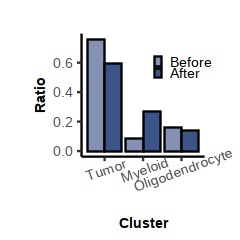

In [42]:
plot.ratio

In [48]:
data.df <- Z_pca_results$x[,select.pcs]%>%as.data.frame

data.df <- data.df%>%mutate(label=as.character(labels))
data.df <- data.df%>%bind_cols(logFC=chr.ratio)

In [43]:
data.df2 <- Y_cellbypc%>%as.data.frame%>%mutate(label=results$ey%>%apply(1,which.max)%>%as.character)

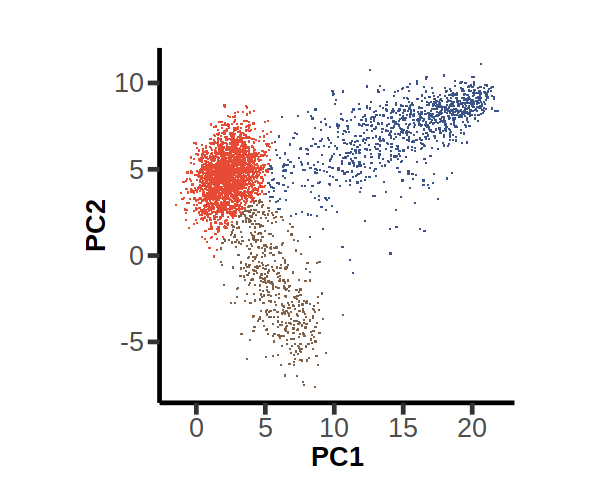

In [103]:
psize(5,4)
plot.pc.y <- (ggplot(data.df2,aes(x=PC1,y=PC2,color=label))+
    geom_point(shape='.',size=3)+
     scale_color_manual(values = colors_[c(1,4,9)])+
    theme_classic())%>%scatter_style2(legend_position = 'none')
plot.pc.y
#ggsave('results/pc.y.pdf',height = 4,width = 4)

In [106]:
dfs = data.df2%>%select(PC1,PC2,label)%>%mutate(type='control')%>%
bind_rows(data.df%>%select(!logFC)%>%mutate(type='perturbation'))

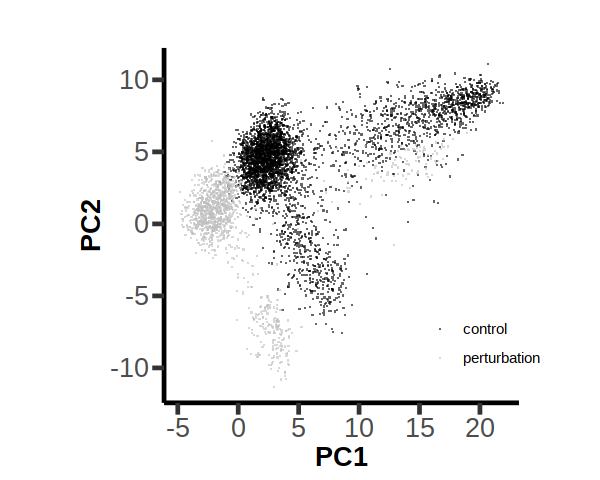

In [107]:
psize(5,4)
plot.pc.y <- (ggplot(dfs,aes(x=PC1,y=PC2,color=type))+
    geom_point(shape='.',size=4,alpha=0.6)+
     scale_color_manual(values = c('black','grey') )+ #colors_[c(5,6)]
    theme_classic())%>%scatter_style2(legend_position = c(0.9,0.18))+
theme(legend.title = element_blank())
plot.pc.y
ggsave('results/pc.combine.pdf',height = 4,width = 5)

In [100]:
dfs$label <- dfs$label%>%gsub('1','tumor',.)%>%gsub('2','myeloid',.)%>%gsub('3','oligodendrocyte',.)

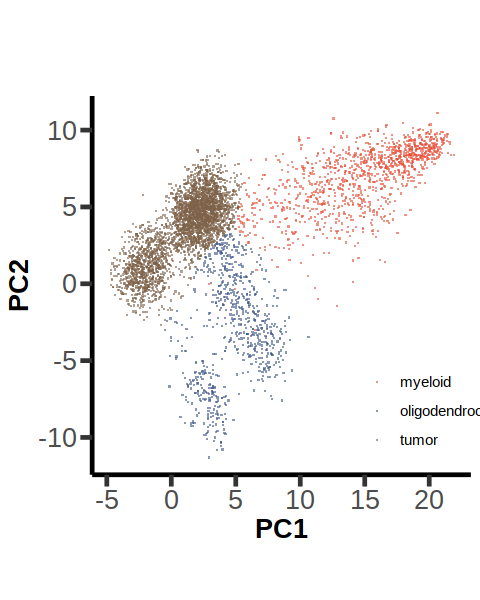

In [105]:
psize(4,5)
plot.pc.y <- (ggplot(dfs,aes(x=PC1,y=PC2,color=label))+
    geom_point(shape='.',size=4,alpha=0.6)+
    scale_color_manual(values = colors_[c(1,4,9)])+
    theme_classic())%>%scatter_style2(legend_position = c(0.9,0.18))+
theme(legend.title = element_blank())
plot.pc.y
ggsave('results/pc.combine2.pdf',height = 4,width = 5)